# Train model with TensorFlow Cloud

[TensorFlow Cloud](https://github.com/tensorflow/cloud) is a Python package that provides APIs for seamless transition from local training to distributed training in Google Cloud.

This notebook will show you how to train your TensorFlow model from a Kaggle notebook and using a Kaggle dataset.

## Step 1: Import Packages (including TensorFlow Cloud)

In [ ]:
import datetime

import numpy as np
import pandas as pd
import tensorflow_cloud as tfc
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

## Step 2: Setup Google Cloud credentials

Add the "Google Cloud SDK" addon from the "Add-ons" menu bar above to allow scheduling an AI training job in your Google Cloud project.

**NOTICE**: TensorFlow Cloud will run the training job in your Google Cloud project. **You will be billed ($$$)** for the resources consumed by this training job.

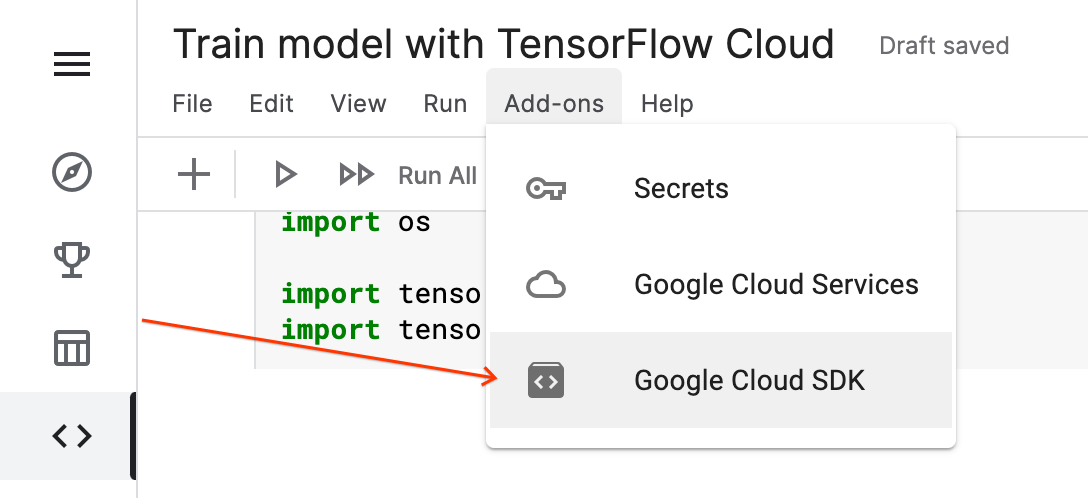


In [ ]:
# Note: Please set GCP_PROJECT_ID to your own Google Cloud project ID.
GCP_PROJECT_ID = 'rosbo-personal'

# Note: Please set GCS_BUCKET to your own Google Cloud Storage (GCS) bucket.
GCS_BUCKET = 'tf-cloud-rosbo-test' # used to save models & docker images

# Note: Please change the job name to reflect the work you are doing.
JOB_NAME = 'kaggle-example'

if not tfc.remote():
    from kaggle_secrets import UserSecretsClient
    UserSecretsClient().set_gcloud_credentials(project=GCP_PROJECT_ID)

gcs_base_path = f'gs://{GCS_BUCKET}/{JOB_NAME}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'

## Step 3: Add Your TensorFlow Training Code

### Specify Parameters

TensorFlow Cloud will run all the cells in this notebook in the Cloud.

You can call `tfc.remote()` to check whether you are running in the Cloud or not and set different value for parameters (e.g. number of epochs). This allows you to easily debug your training code locally before sending the larger training job to the Cloud.

In [ ]:
# These settings apply when running in this Kaggle notebook.
NUM_EPOCHS = 1 # Train a single epoch to test the training code works.
callbacks = None

# These settings apply when running on TensorFlow Cloud
if tfc.remote():    
    NUM_EPOCHS = 100 # Train more epochs on TensorFlow Cloud
    
    callbacks = [
        # TensorBoard will store logs for each epoch & graph performance for us.
        tf.keras.callbacks.TensorBoard(log_dir=f'{gcs_base_path}/tensorboard', histogram_freq=1),
        # ModelCheckpoint will save models after each epoch for retrieval later.
        tf.keras.callbacks.ModelCheckpoint(gcs_base_path + '/checkpoints/save_at_{epoch}'),
    ]

### Read & Prepare Training Data

The model will be trained to recognize handwritten digits on the Kaggle MNIST dataset used in the [Kaggle Digit Recognizer competition](https://www.kaggle.com/c/digit-recognizer).

In [ ]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
x_train = train.iloc[:,1:].values.astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(train.iloc[:,0].astype('int32'))
x_train = x_train.reshape(-1, 28, 28, 1)

print("Splitting input in train and validation sets...")
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.10)
print("Training:", x_train.shape, y_train.shape)
print("Validation:", x_validation.shape, y_validation.shape)

### Define & Train TensorFlow Model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

print(model.summary())

print("Training...")
model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=32)
print("Training complete")

### Evaluate

The model is evaluated against the validation set.

In [ ]:
model.evaluate(x_validation, y_validation, return_dict=True)

### Save model

We save the trained model to Cloud Storage **only when running in the Cloud**.

In [ ]:
if tfc.remote():
    model.save(f'{gcs_base_path}/model')

## Step 4: Train model on TensorFlow Cloud

For this example, we use a single machine with 16 cores & 60 GB of memory.

You can use larger machines, add accelerators or add additional machines to perform the training. To learn more about this, you can read the [TensorFlow Cloud cluster & distribution strategy configuration](https://github.com/tensorflow/cloud#cluster-and-distribution-strategy-configuration) documentation.

**IMPORTANT**: TensorFlow Cloud will use the same environment (packages, drivers, etc) than your notebook. If you are using TensorFlow Cloud with machines with accelerators, make sure to select "GPU" in the accelerator setting in the right panel of this notebook.

In [ ]:
print("Training on TensorFlow Cloud...")
tfc.run(
    distribution_strategy='auto',
    docker_image_bucket_name=GCS_BUCKET,
    chief_config=tfc.MachineConfig(
        cpu_cores=16,
        memory=60,
        accelerator_type=tfc.AcceleratorType.NO_ACCELERATOR,
        accelerator_count=0
    ),
    job_labels={"job": JOB_NAME},
)

## Step 5: Find the path to your trained model

Now that you're model has been trained on Cloud AI Platform, you can access the logs of your training job to get the path to your model.

Search for `MODEL_PATH` in the training jobs logs.

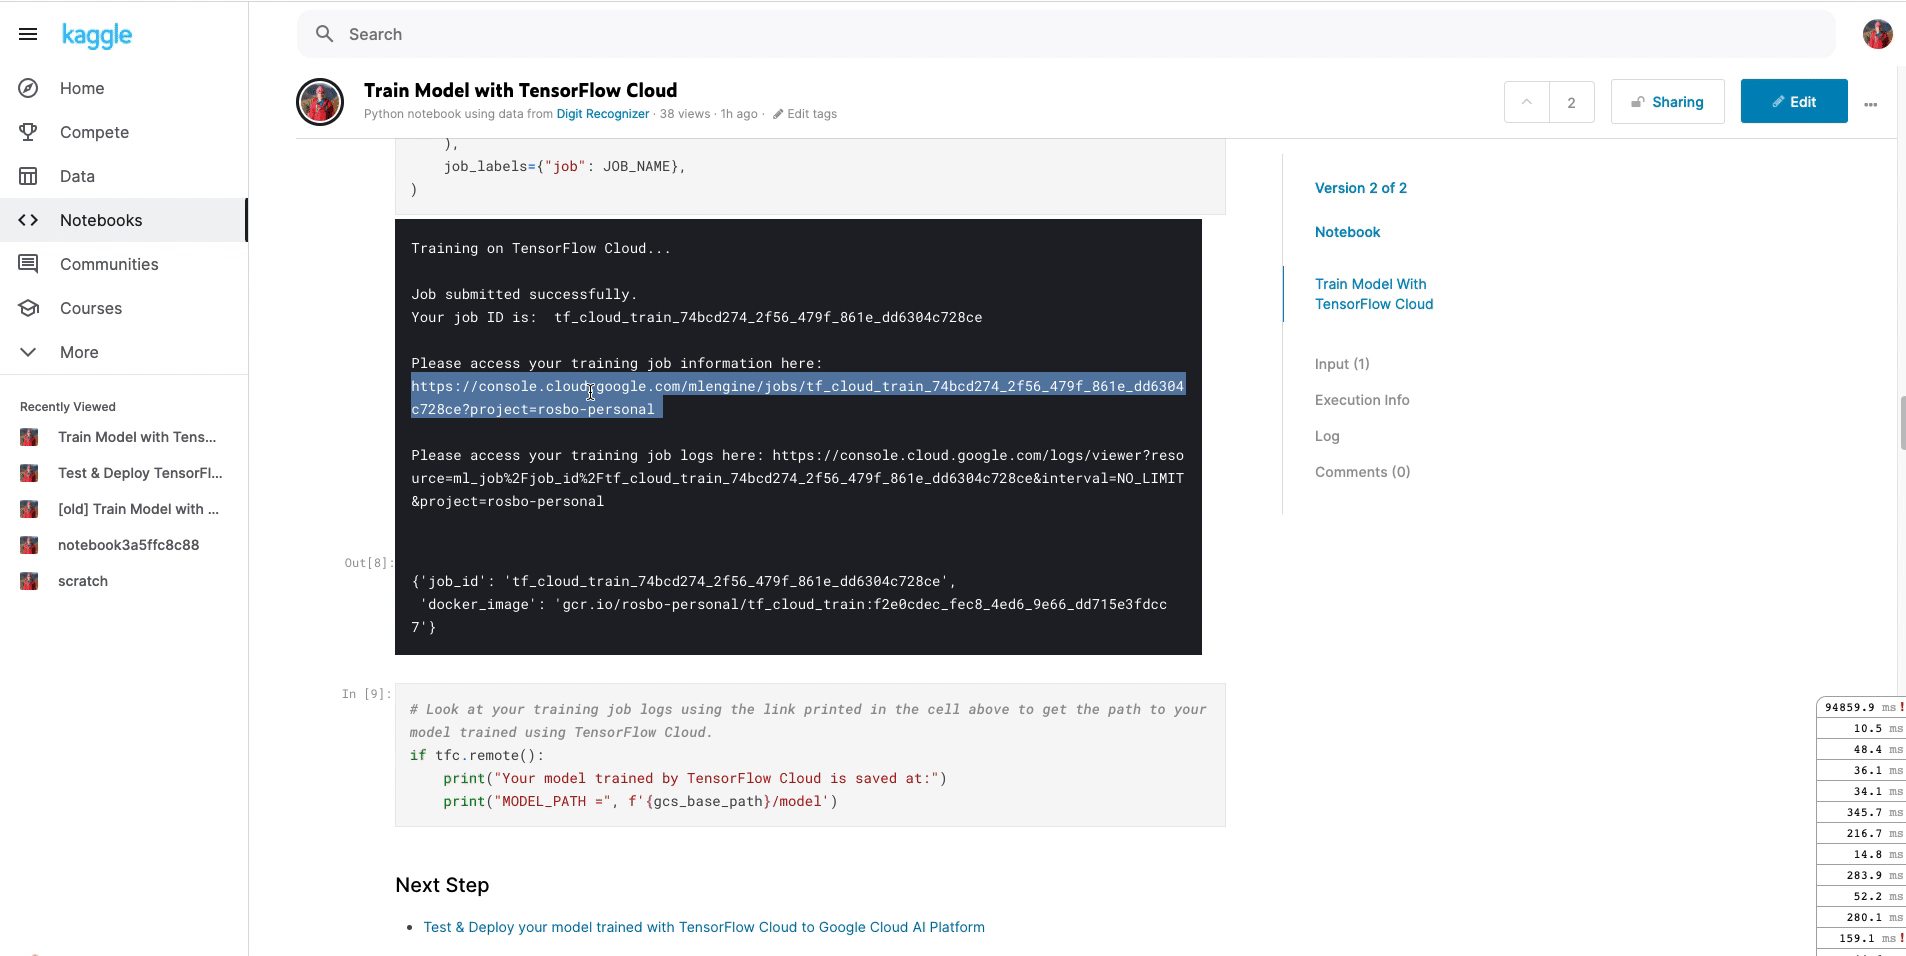

In [ ]:
if tfc.remote():
    print("Your model trained by TensorFlow Cloud is saved at:")
    print("MODEL_PATH =", f'{gcs_base_path}/model')

## Next Step
    
- [Test & Deploy your model trained with TensorFlow Cloud to Google Cloud AI Platform](https://www.kaggle.com/rosebv/test-deploy-tensorflow-model-to-ai-platform)